#  Lab 1 - Revision Histories

**Professor [Brian Keegan](https://www.brianckeegan.com)**  
**[Department of Information Science, CU Boulder](www.colorado.edu/cmci/academics/information-science)**  
This notebook is copyright and made available under the [Apache License v2.0](https://creativecommons.org/licenses/by-sa/4.0/) license.

This is the first of five lab notebooks that will explore how to do some introductory data extraction and analysis from Wikipedia data. This lab will use a combination of MySQL and Python to retrieve the revision histories for a selection of articles. You do not need to be fluent in either to complete the lab, but there are many options for extending the analyses we do here by using more advanced queries and scripting methods.

**Acknowledgements**  
I'd like to thank the Wikimedia Foundation for the [PAWS system](https://wikitech.wikimedia.org/wiki/PAWS) and [related Wikitech infrastructure](https://wikitech.wikimedia.org/wiki/Main_Page) that this workbook runs within. Yuvi Panda, Aaron Halfaker, Jonathan Morgan, and Dario Taraborelli have all provided crucial support and feedback.

## Confirm basic Python commands work

In [1]:
a = 1
b = 2
a+b

3

In [2]:
list(range(0,5))

[0, 1, 2, 3, 4]

In [3]:
your_name = 'Brian Keegan'
print("Hello, {0}".format(your_name))

Hello, Brian Keegan


## Import modules and setup environment

Load up all the libraries we'll need to connect to the database, retrieve information for analysis, and visualizing results.

In [4]:
# Makes the plots appear within the notebook
%matplotlib inline

# Two fundamental packages for doing data manipulation
import numpy as np                   # http://www.numpy.org/
import pandas as pd                  # http://pandas.pydata.org/

# Two related packages for plotting data
import matplotlib.pyplot as plt      # http://matplotlib.org/
import seaborn as sb                 # https://stanford.edu/~mwaskom/software/seaborn/

# Two packages for accessing the MySQL server
import pymysql                       # http://pymysql.readthedocs.io/en/latest/
import os                            # https://docs.python.org/3.4/library/os.html

# Setup the code environment to use plots with a white background and DataFrames show more columns and rows
sb.set_style('whitegrid')
pd.options.display.max_columns = 100
pd.options.display.max_rows = 110

## Setup a connection to the English Wikipedia database

Retrieve the host name, username, and (encrypted) password associated with your account so you can login to the database.

In [5]:
host, user, password = os.environ['MYSQL_HOST'], os.environ['MYSQL_USERNAME'], os.environ['MYSQL_PASSWORD']

Connect to the system using the creditials from above, then select the database for the English Wikipedia.

In [6]:
conn = pymysql.connect(host=host,user=user,password=password,database='enwiki_p',connect_timeout=3600)
conn.cursor().execute('use enwiki_p');

## What tables are available for use?

In [7]:
pd.read_sql_query('show tables',conn)

,Tables_in_enwiki_p
0,abuse_filter
1,abuse_filter_action
2,abuse_filter_log
3,aft_article_answer
4,aft_article_answer_text
5,aft_article_feedback
6,aft_article_feedback_properties
7,aft_article_feedback_ratings_rollup
8,aft_article_feedback_select_rollup
9,aft_article_field


In [8]:
s = """
        SELECT 
            *
        FROM 
            wikilove_log
        LIMIT
            5
    """
    
pd.read_sql_query(s,conn)

,wll_id,wll_timestamp,wll_sender,wll_sender_registration,wll_sender_editcount,wll_receiver,wll_receiver_registration,wll_receiver_editcount,wll_type,wll_subject,wll_message,wll_email
0,1,b'20110630183430',10796336,b'20091016234100',92,10796336,b'20091016234100',92,b'food-pie',b'A pie for you!',b'here is another pie for me',0
1,2,b'20110630183437',59944,b'20040419234618',34358,59944,b'20040419234618',34358,b'food-baklava',b'Some baklava for you!',b'testing',0
2,3,b'20110630183525',10796336,b'20091016234100',93,10796336,b'20091016234100',93,b'food-baklava',b'Some baklava for you!',b'here is another wikilove!',0
3,4,b'20110630183537',59944,b'20040419234618',34359,59944,b'20040419234618',34359,b'makeyourown',b'test',b'Howdy',0
4,5,b'20110630183611',12732325,b'20100714203639',119,59944,b'20040419234618',34360,b'kitten',b'A kitten for you!',b'Hurky hurky test',0


## Important note

Article page titles need to be separated by underscores "\_" rather than spaces. It's easy to replace spaces with underscores using the `replace` method called on the string.

In [9]:
page_title = 'Mitt Romney'.replace(' ','_')
page_title

'Mitt_Romney'

## Get revisions for a single article

Write a function `get_page_revisions` that takes the name of a Wikipedia page and its namespace and use the database connection to return a pandas DataFrame containing all the revisions for the article. Some of the fields inside needs to be cleaned up by converting to other data types to help with analysis in later steps.

In [10]:
def get_page_revisions(page_title,namespace,conn):
    """ Takes a page title and returns its revision history.
      page_title = a string for the page title to get its revisions
      namespace = an int to get the revisions from a specific namespace
      conn = a database connection
      
    Returns:
      A pandas DataFrame containing all the article revisions and page information
    """
    # In case you pass a page title with spaces in it, replace the spaces with underscores
    page_title = page_title.replace(' ','_')

    # The MySQL query string used to retrieve the data. By line, it is
    ## selecting all columns 
    ## from the "revisions" table
    ## joining the "page" table on it
    ## using the page_id and rev_page columns as keys
    ## limiting the results to entries that occur in the namespace and pagetitle
    ## and ordering the results by the timestamp
    s = """
            SELECT 
                *
            FROM 
                revision 
            JOIN 
                page ON page.page_id = revision.rev_page
            WHERE 
                page.page_namespace = {1} AND page.page_title = '{0}' 
            ORDER BY 
                revision.rev_timestamp ASC
        """.format(page_title,namespace)
    
    # Use the connection to run the query and return the results as a DataFrame
    _df = pd.read_sql_query(s,conn)

    # Some of the results have a "bytestring" format
    byte_columns = ['rev_comment','rev_user_text','rev_timestamp','rev_sha1','page_content_model',
                    'page_title','page_restrictions','page_touched','page_links_updated']
    
    # For each column, convert it from bytestring to a utf8 string
    for col in byte_columns:
        _df[col] = _df[col].str.decode('utf8')

    # Several of the columns are timestamps. Convert to datetimes
    _df['rev_timestamp'] = _df['rev_timestamp'].apply(lambda x:pd.datetime.strptime(x,'%Y%m%d%H%M%S'))
    _df['page_touched'] = _df['page_touched'].apply(lambda x:pd.datetime.strptime(x,'%Y%m%d%H%M%S'))
    _df['page_links_updated'] = _df['page_links_updated'].apply(lambda x:pd.datetime.strptime(x,'%Y%m%d%H%M%S'))
    
    # Return the data
    return _df

Use the function to get the revisions for a single article and use the `.head()` method to inspect the first 5 rows in the DataFrame.

In [11]:
rev_df = get_page_revisions('Mitt Romney',0,conn)
rev_df.head()

,rev_id,rev_page,rev_text_id,rev_comment,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len,rev_parent_id,rev_sha1,rev_content_model,rev_content_format,page_id,page_namespace,page_title,page_restrictions,page_counter,page_is_redirect,page_is_new,page_random,page_touched,page_links_updated,page_latest,page_len,page_content_model
0,2229556,426208,0.0,,30528,Academic Challenger,2004-01-10 07:37:48,0,0,237.0,0,igni8ilffo85cqdcxtf2nffgel4ua9v,None,None,426208,0,Mitt_Romney,,0,0,0,0.487268,2016-09-24 00:37:57,2016-09-24 00:38:05,740891468,251636,wikitext
1,2671292,426208,0.0,SLC Olympics.,0,18.24.0.120,2004-01-25 21:23:55,0,0,369.0,2229556,1m9i39rbo5nmu8klkh2rvtzgmi79qlp,None,None,426208,0,Mitt_Romney,,0,0,0,0.487268,2016-09-24 00:37:57,2016-09-24 00:38:05,740891468,251636,wikitext
2,2802157,426208,0.0,,47982,Xinoph,2004-03-07 22:46:47,0,0,972.0,2671292,13k734g9hhg0c0gfoeajlrbgm6qwk36,None,None,426208,0,Mitt_Romney,,0,0,0,0.487268,2016-09-24 00:37:57,2016-09-24 00:38:05,740891468,251636,wikitext
3,3064041,426208,0.0,Paragraph formatting. Info about father.,64194,Chrisn4255,2004-03-17 08:37:03,0,0,1139.0,2802157,om843tubijlwo0i3qxyih3i0si82111,None,None,426208,0,Mitt_Romney,,0,0,0,0.487268,2016-09-24 00:37:57,2016-09-24 00:38:05,740891468,251636,wikitext
4,3435894,426208,0.0,fixing link,32345,Acegikmo1,2004-04-05 06:17:41,1,0,1152.0,3064041,rkd11yolu9udl9lkehw8cg0bnwhuuok,None,None,426208,0,Mitt_Romney,,0,0,0,0.487268,2016-09-24 00:37:57,2016-09-24 00:38:05,740891468,251636,wikitext


Count the total number of revisions in the article.

In [12]:
len(rev_df)

11046

Count the total number of unique users contributing to the article.

In [13]:
len(rev_df['rev_user_text'].unique())

2654

When was the first revision made to the article?

In [14]:
rev_df['rev_timestamp'].min()

Timestamp('2004-01-10 07:37:48')

When was the most recent revision made to the article?

In [15]:
rev_df['rev_timestamp'].max()

Timestamp('2016-09-24 00:37:57')

How has the size of the article changed over time?

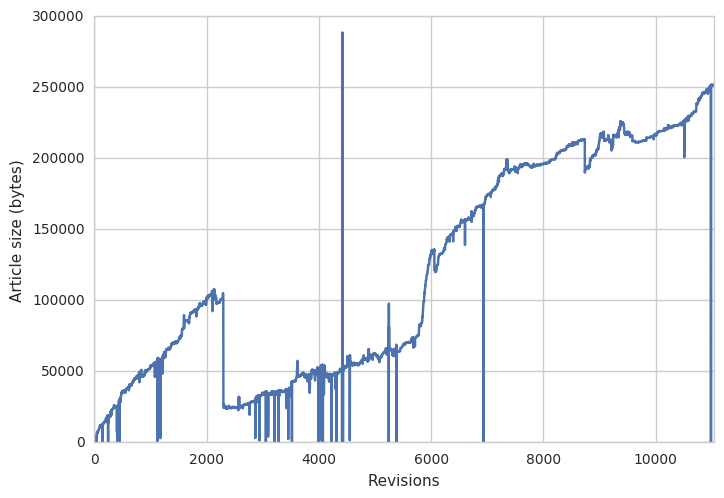

In [16]:
ax = rev_df['rev_len'].plot()
ax.set_xlabel('Revisions')
ax.set_ylabel('Article size (bytes)')

Who made the largest change to the article?

In [17]:
# Use the idxmax() method to return the index value for the largest value in the series
loc_max_revision = rev_df['rev_len'].idxmax()

# Show the values of a single row
rev_df.ix[loc_max_revision]

rev_id                                      173926275
rev_page                                       426208
rev_text_id                                         0
rev_comment                                          
rev_user                                            0
rev_user_text                          76.197.212.135
rev_timestamp                     2007-11-26 17:47:03
rev_minor_edit                                      0
rev_deleted                                         0
rev_len                                        288466
rev_parent_id                               173917961
rev_sha1              azle9orolzo3vh81tn7d4i7zehlxvqk
rev_content_model                                None
rev_content_format                               None
page_id                                        426208
page_namespace                                      0
page_title                                Mitt_Romney
page_restrictions                                    
page_counter                

Go inspect what this largest revision was. Actually this specific example is ***extremely NSFW.***

In [18]:
rev_id = rev_df.ix[loc_max_revision,'rev_id']
print('https://en.wikipedia.org/w/index.php?oldid={0}'.format(rev_id))

https://en.wikipedia.org/w/index.php?oldid=173926275


## Group revisions by date

Muliple revisions can be made in a single day. We want to be able to count the number of revisions per day and how the article's length has changed over time.

In [19]:
# For each timestamp extract only its date (ignoring the time of day) 
# and save as a new column "rev_date"
rev_df['rev_date'] = rev_df['rev_timestamp'].apply(lambda x:x.date())

# Compare the full "rev_timestamp" to the new "rev_date"
rev_df[['rev_timestamp','rev_date']].head()

,rev_timestamp,rev_date
0,2004-01-10 07:37:48,2004-01-10
1,2004-01-25 21:23:55,2004-01-25
2,2004-03-07 22:46:47,2004-03-07
3,2004-03-17 08:37:03,2004-03-17
4,2004-04-05 06:17:41,2004-04-05


What dates had the most revisions in a single day? A simple way of doing this is to count the number of times each "rev_date" occurs in the data with the `value_counts` method. Let's look at the top 10, 5 of which are in October 2012 in the weeks before the Election Day.

In [20]:
rev_df['rev_date'].value_counts().head(10)

2012-10-07    77
2012-10-06    73
2012-10-13    71
2012-05-13    65
2007-12-13    58
2012-07-27    54
2012-10-05    50
2012-05-30    50
2012-10-03    50
2012-07-20    49
Name: rev_date, dtype: int64

We can use the groupby functionality to create "baby" DataFrames having all the same particular value. For example, we can group by the date and each of the baby DataFrames would be all the revisions that occurred on that date. Store the groupby in the "rev_gb_date" object for subsequent steps. 

Inspect a single baby DataFrame by passing the key (the date values we grouped on) to the `get_group` method and look at the first 5 entries.

In [21]:
rev_gb_date = rev_df.groupby(['rev_date'])

_date = pd.Timestamp('2012-10-07').date()
rev_gb_date.get_group(_date).head(5)

,rev_id,rev_page,rev_text_id,rev_comment,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len,rev_parent_id,rev_sha1,rev_content_model,rev_content_format,page_id,page_namespace,page_title,page_restrictions,page_counter,page_is_redirect,page_is_new,page_random,page_touched,page_links_updated,page_latest,page_len,page_content_model,rev_date
9915,516397493,426208,0.0,"/* Political positions */ ce, improve prose",11243047,GabeMc,2012-10-07 00:11:21,0,0,215302.0,516387652,sylmwj2deuw63nk04da8uv1u2bgt8t3,None,None,426208,0,Mitt_Romney,,0,0,0,0.487268,2016-09-24 00:37:57,2016-09-24 00:38:05,740891468,251636,wikitext,2012-10-07
9916,516398755,426208,0.0,"/* Political positions */ ce, avoid redundancy...",11243047,GabeMc,2012-10-07 00:22:12,0,0,215311.0,516397493,lsh4gi37dd000s67qsulfv35uf0i16i,None,None,426208,0,Mitt_Romney,,0,0,0,0.487268,2016-09-24 00:37:57,2016-09-24 00:38:05,740891468,251636,wikitext,2012-10-07
9917,516403792,426208,0.0,clarify that church positions were not full time,61960,Anythingyouwant,2012-10-07 01:06:39,0,0,215338.0,516398755,pe5aabxcd8lvll3wv9y5c3n8bbhrc51,None,None,426208,0,Mitt_Romney,,0,0,0,0.487268,2016-09-24 00:37:57,2016-09-24 00:38:05,740891468,251636,wikitext,2012-10-07
9918,516405141,426208,0.0,"/* University, France mission, marriage, and c...",61960,Anythingyouwant,2012-10-07 01:19:16,0,0,215346.0,516403792,d5lo1cm9nzg2oh7ply53xj9hdq7cua0,None,None,426208,0,Mitt_Romney,,0,0,0,0.487268,2016-09-24 00:37:57,2016-09-24 00:38:05,740891468,251636,wikitext,2012-10-07
9919,516405398,426208,0.0,"/* University, France mission, marriage, and c...",61960,Anythingyouwant,2012-10-07 01:21:48,0,0,215357.0,516405141,2mbiudrlxffpz90zx4pi5cq33xywkpb,None,None,426208,0,Mitt_Romney,,0,0,0,0.487268,2016-09-24 00:37:57,2016-09-24 00:38:05,740891468,251636,wikitext,2012-10-07


### Compute unique revisions per day

We can also use aggregate functionality to perform computations efficiently across all the baby DataFrames.

In [22]:
daily_revs = rev_gb_date.agg({'rev_id':pd.Series.nunique})
daily_revs.head() 

,rev_id
rev_date,
2004-01-10,1
2004-01-25,1
2004-03-07,1
2004-03-17,1
2004-04-05,1


Reindex the axis to make it continuous over the date range.

In [23]:
# Compute the first and last days revisions were observed
_min, _max = daily_revs.index.min(), daily_revs.index.max()

# Create a new index that is continuous over the whoel date range
_ix = pd.date_range(_min,_max)

# Reindex the daily revisions over the continuous date range filling in the blanks with 0s
daily_revs_reindexed = daily_revs.reindex(_ix).fillna(0)
daily_revs_reindexed.head()

,rev_id
2004-01-10,1.0
2004-01-11,0.0
2004-01-12,0.0
2004-01-13,0.0
2004-01-14,0.0


What was the most active day of editing?

In [24]:
daily_revs_reindexed['rev_id'].sort_values(ascending=False).head(5)

2012-10-07    77.0
2012-10-06    73.0
2012-10-13    71.0
2012-05-13    65.0
2007-12-13    58.0
Name: rev_id, dtype: float64

Plot the number of revisions by day.

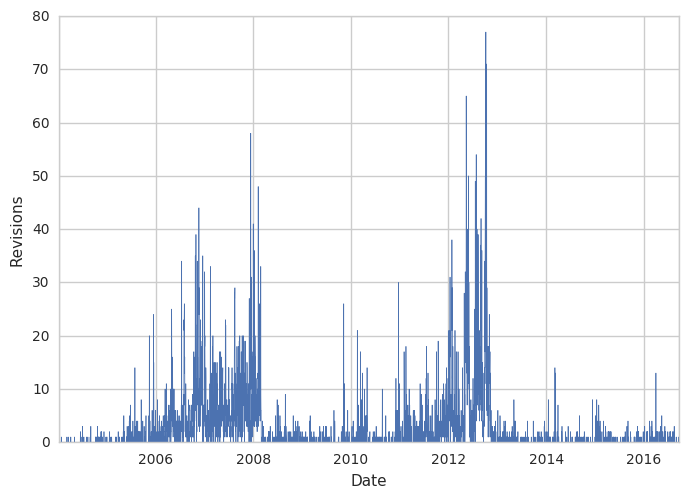

In [25]:
ax = daily_revs_reindexed['rev_id'].plot(lw=.5)

# Label the axes
ax.set_xlabel('Date')
ax.set_ylabel('Revisions')

This is pretty noisy. We can clean it up by applying a rolling mean over a 60-day window.

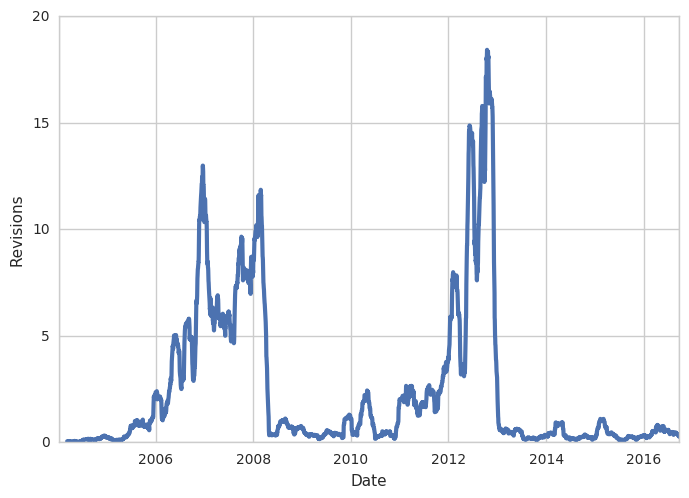

In [70]:
smoothed_s = daily_revs_reindexed['rev_id'].rolling(60).mean()
ax = smoothed_s.plot(lw=3)

# Label the axes
ax.set_xlabel('Date')
ax.set_ylabel('Revisions')

Plot the cumulative sum of the number of revisions over time using the `cumsum` method.

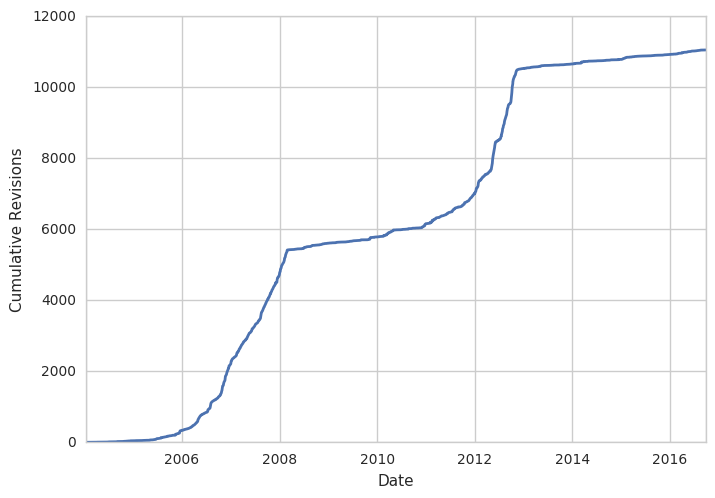

In [26]:
ax = daily_revs_reindexed['rev_id'].cumsum().plot(lw=2)

# Label the axes
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Revisions')

### Compute article length by day

Using the same "rev_gb_date" object, aggregate each of the baby DataFrames and compute the median article size ("rev_len"). Reindex again to make a continuous time axis.

In [27]:
daily_length = rev_gb_date.agg({'rev_len':np.median})

# Reindex
daily_length_reindexed = daily_length.reindex(_ix).fillna(method='ffill')
daily_length_reindexed.head()

,rev_len
2004-01-10,237.0
2004-01-11,237.0
2004-01-12,237.0
2004-01-13,237.0
2004-01-14,237.0


Plot the reindexed series, making the y-axis be on a log scale to pick up detail in the early days when the article was orders of magnitude smaller.

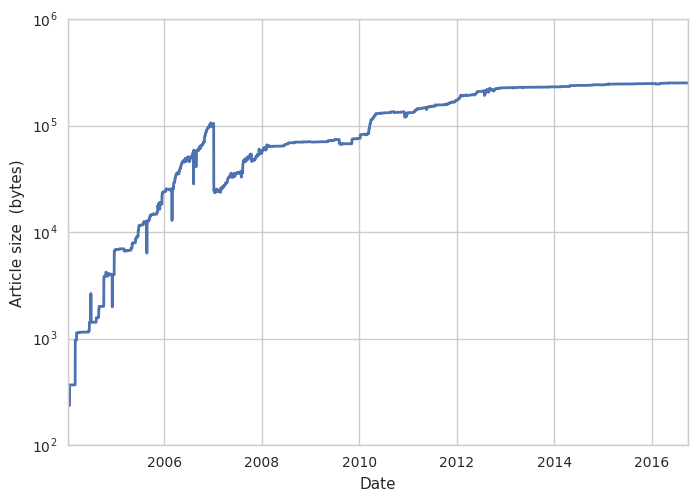

In [28]:
ax = daily_length_reindexed['rev_len'].plot(lw=2,logy=True)

# Label the axes
ax.set_xlabel('Date')
ax.set_ylabel('Article size  (bytes)')

### Compute diffs on time and article size

The "rev_len" only records the length of the revision at that point in time. By taking the difference with the previous observation, we can compute how much net content the user added or removed from the previous revision. Using the `diff` method on the "rev_len" series, we store the resulting differences as "rev_len_diff". 

Compare the first five elements of the two series to verify it's worked as intended.

In [29]:
# Compute the diff and store as a new series
rev_df['rev_len_diff'] = rev_df['rev_len'].diff()

# Verify the differences are accurate
rev_df[['rev_len','rev_len_diff']].head()

,rev_len,rev_len_diff
0,237.0,NaN
1,369.0,132.0
2,972.0,603.0
3,1139.0,167.0
4,1152.0,13.0


Do some more cleanup of the diffs. In particular, when a revision is deleted (which is rare) the "rev_len" value is null, which makes the diff null as well. Make the first revision's "rev_len_diff" equal to the size of the article and then ffill the other nan values.

In [30]:
# Set the revision lengths for the null rows to be the previous value
rev_df['rev_len'] = rev_df['rev_len'].fillna(method='ffill')

# Compute the diffs again 
rev_df['rev_len_diff'] = rev_df['rev_len'].diff()

# Set the value for the first rev_len_diff to be the size of the rev_len
rev_df.loc[0,'rev_len_diff'] = rev_df.loc[0,'rev_len']

# Verify the differences are accurate
rev_df[['rev_len','rev_len_diff']].head()

,rev_len,rev_len_diff
0,237.0,237.0
1,369.0,132.0
2,972.0,603.0
3,1139.0,167.0
4,1152.0,13.0


Similarly, the "rev_timestamp" series only records the time when the revision occurred. By taking the difference with the previous revision, we can compute how much time has elapsed since the last edit. Using the `diff` method again on the  "rev_timestamp" series, we store the resulting differences as "ref_timestamp_diff". 

The resulting values are [Timedeltas](http://pandas.pydata.org/pandas-docs/stable/timedeltas.html) which we convert back to number of day floats by dividing by `np.timedelta64`.

Compare the first five elements of the two series to verify it's worked as intended.

In [31]:
# Compute the diff and store as a new series
rev_df['rev_timestamp_diff'] = rev_df['rev_timestamp'].diff()

# Convert the values of the new series to floats by dividing by 1 day time delta.
rev_df['rev_timestamp_diff'] = rev_df['rev_timestamp_diff'].apply(lambda x:x/np.timedelta64(1,'D'))

# Verify the differences are accurate.
rev_df[['rev_timestamp','rev_timestamp_diff']].head()

,rev_timestamp,rev_timestamp_diff
0,2004-01-10 07:37:48,NaN
1,2004-01-25 21:23:55,15.573692
2,2004-03-07 22:46:47,42.057546
3,2004-03-17 08:37:03,9.409907
4,2004-04-05 06:17:41,18.903218


### Combine all the computations with one daily DataFrame

Because we added new series to the "rev_df" we need to re-run the groupby to update it. We can also combine all the different aggregate functions we did before into one step by defining an "agg_dict" that applies an aggregation function over the values in a specific column. This will return a DataFrame with only a subset of columns with the aggregated values we specified.

In [32]:
# Groupby again
rev_gb_date = rev_df.groupby(['rev_date'])

# Define an aggregation mapping of functions to columns names
agg_dict_date = {'rev_id':pd.Series.nunique,
                  'rev_len':np.median,
                  'rev_len_diff':np.median,
                  'rev_timestamp_diff':np.mean
                 }

# Execiute the aggregation functions on the groupby object
rev_agg_date = rev_gb_date.agg(agg_dict_date)

# Reindex to continuous dates
rev_agg_date = rev_agg_date.reindex(_ix)

# Fill in the resulting values of the reindexed and aggregated "rev_len" from the last value
rev_agg_date[['rev_len']] = rev_agg_date[['rev_len']].fillna(method='ffill')

# Fill in the resulting values of the reindexed and aggregated other series as 0s.
rev_agg_date[['rev_id','rev_len_diff']] = rev_agg_date[['rev_id','rev_len_diff']].fillna(0)
#rev_agg_date[['rev_id','rev_len_diff','rev_timestamp_diff']] = rev_agg_date[['rev_id','rev_len_diff','rev_timestamp_diff']].fillna(0)

# Show the first 10 values to verify it's worked as intended
rev_agg_date.tail(10)

,rev_len,rev_len_diff,rev_timestamp_diff,rev_id
2016-09-15,251695.0,0.0,NaN,0.0
2016-09-16,251695.0,0.0,NaN,0.0
2016-09-17,251695.0,0.0,NaN,0.0
2016-09-18,251636.0,-59.0,16.369988,1.0
2016-09-19,251636.0,0.0,NaN,0.0
2016-09-20,251636.0,0.0,NaN,0.0
2016-09-21,251636.0,0.0,NaN,0.0
2016-09-22,251636.0,0.0,NaN,0.0
2016-09-23,251636.0,0.0,NaN,0.0
2016-09-24,251636.0,0.0,5.920498,1.0


Plot the changes in the average time since the last revision by day.

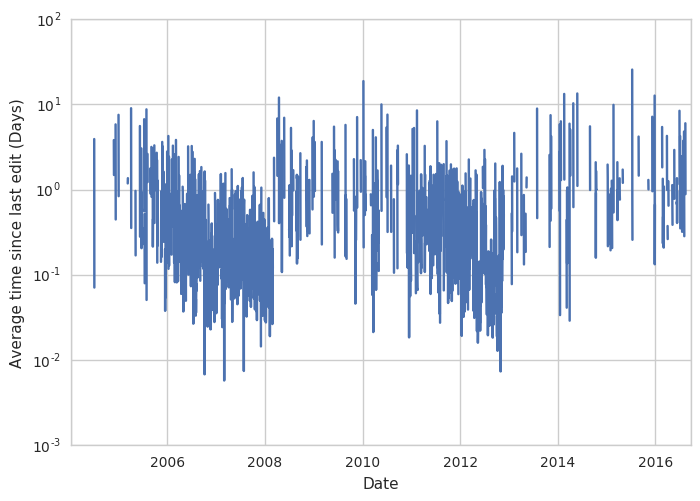

In [33]:
_s = rev_agg_date['rev_timestamp_diff']
ax = _s.plot(logy=True)
ax.set_xlabel('Date')
ax.set_ylabel('Average time since last edit (Days)')

That's pretty noisy. We can apply the `rolling` method over a 60-day window and get the mean to smooth out some of the noise.

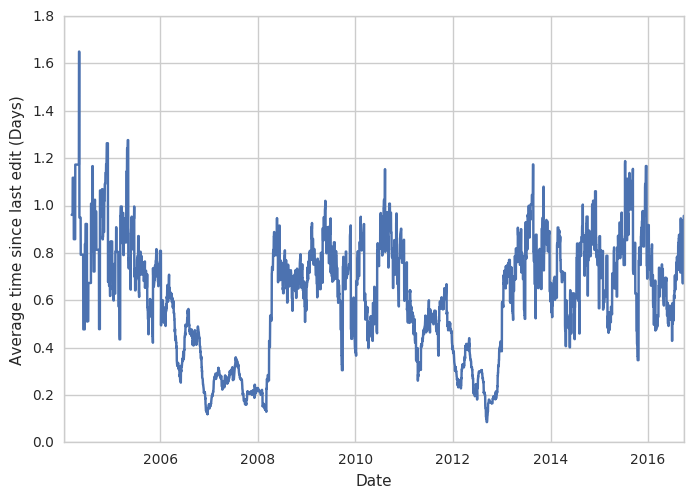

In [34]:
_s = rev_agg_date['rev_timestamp_diff'].fillna(0).rolling(60).mean()
ax = _s.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Average time since last edit (Days)')

Similarly, what was the median size of a change to the article over time?

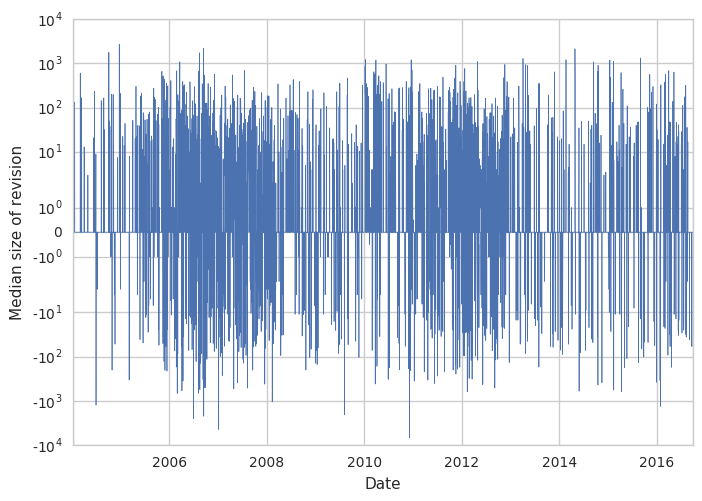

In [35]:
_s = rev_agg_date['rev_len_diff']
ax = _s.plot(lw=.5)
ax.set_xlabel('Date')
ax.set_ylabel('Median size of revision')
ax.set_yscale('symlog')

Again, pretty noisy. We can cleanup with a rolling mean over a 60-day window.

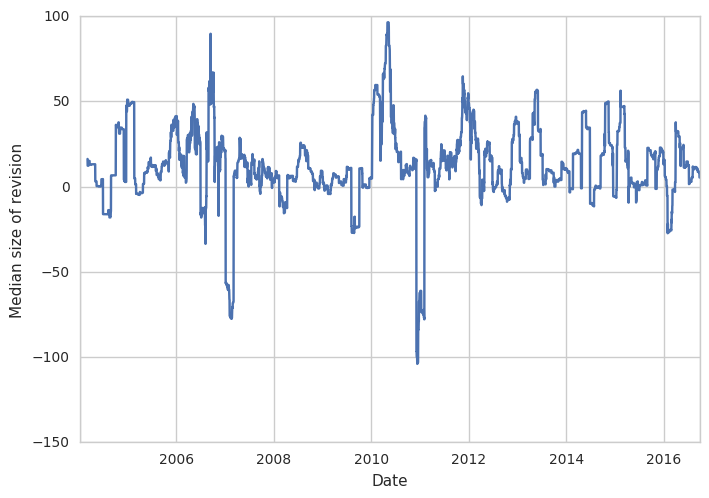

In [36]:
_s = rev_agg_date['rev_len_diff'].rolling(60).mean()
ax = _s.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Median size of revision')

## Top editors on the article

Which editors made the most contributions to the article?

In [37]:
top_users = rev_df['rev_user_text'].value_counts()
top_users.head(10)

Wasted Time R              1394
Anythingyouwant             754
GabeMc                      421
Notmyrealname               196
Yellowdesk                  190
Hodgdon's secret garden     152
Dezastru                    133
72Dino                      126
Cwobeel                     113
Eustress                    102
Name: rev_user_text, dtype: int64

This extremely skewed distribution of activity is characteristic of many online participation patterns: the "long tail" where less than 20% of users are responsible for more than 20% of contributions.

In [38]:
rev_count_occurrences = top_users.value_counts().reset_index()
rev_count_occurrences = rev_count_occurrences.rename(columns={'index':'Revision count','rev_user_text':'Occurrences'})
rev_count_occurrences.head()

,Revision count,Occurrences
0,1,1664
1,2,406
2,3,167
3,4,121
4,5,68


Plot the resulting distribution on log-log axes to see the shape of the long-tail distribution.

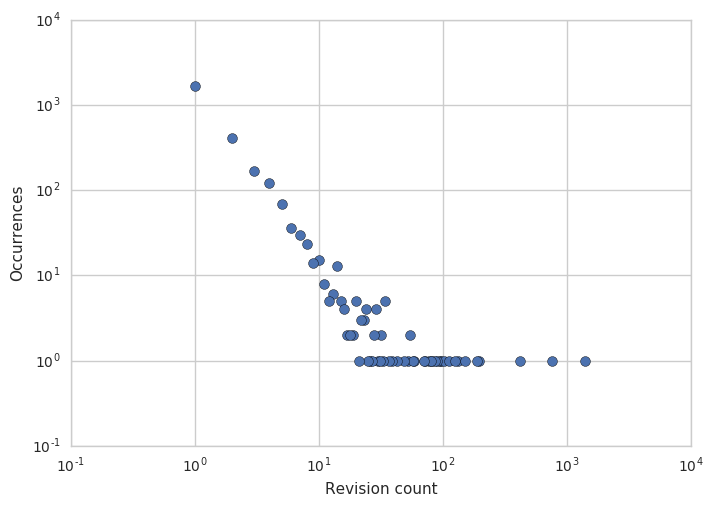

In [39]:
rev_count_occurrences.plot(x='Revision count',y='Occurrences',kind='scatter',logy=True,logx=True,s=50)

### Group revisions by users

We can also use the groupby-aggregate framework to group all the revisions together by the users who made them, rather than grouping revisions by the date as we did before.

In [40]:
rev_gb_user = rev_df.groupby(['rev_user_text'])

Look at a baby DataFrame within the groupby for a single user. These are all the revisions made by this user to this article.

In [41]:
rev_gb_user.get_group('Eustress').head()

,rev_id,rev_page,rev_text_id,rev_comment,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len,rev_parent_id,rev_sha1,rev_content_model,rev_content_format,page_id,page_namespace,page_title,page_restrictions,page_counter,page_is_redirect,page_is_new,page_random,page_touched,page_links_updated,page_latest,page_len,page_content_model,rev_date,rev_len_diff,rev_timestamp_diff
5002,186165588,426208,0.0,"/* Campaign for United States President, 2008 ...",5781611,Eustress,2008-01-22 18:53:17,0,0,62602.0,186147853,3s2mhxwf7zre265xnoclini8x2j5vuu,None,None,426208,0,Mitt_Romney,,0,0,0,0.487268,2016-09-24 00:37:57,2016-09-24 00:38:05,740891468,251636,wikitext,2008-01-22,32.0,0.059618
5003,186166154,426208,0.0,"/* Religious background */ Citation or not, th...",5781611,Eustress,2008-01-22 18:56:07,0,0,62258.0,186165588,kb0myuxejjcq13abgth1qu1n91uje8c,None,None,426208,0,Mitt_Romney,,0,0,0,0.487268,2016-09-24 00:37:57,2016-09-24 00:38:05,740891468,251636,wikitext,2008-01-22,-344.0,0.001968
5278,191953237,426208,0.0,/* Religious background */ Neither of the sour...,5781611,Eustress,2008-02-16 23:44:01,0,0,65452.0,191953125,39djnfp4f0y7d3d01gd2r726ilh5m98,None,None,426208,0,Mitt_Romney,,0,0,0,0.487268,2016-09-24 00:37:57,2016-09-24 00:38:05,740891468,251636,wikitext,2008-02-16,-59.0,0.000440
5600,259363469,426208,0.0,[[WP:UNDO|Undid]] revision 259358412 by [[Spec...,5781611,Eustress,2008-12-21 16:32:31,0,0,70668.0,259358412,cp87oft75dawqa62dszytdtkh8biu48,None,None,426208,0,Mitt_Romney,,0,0,0,0.487268,2016-09-24 00:37:57,2016-09-24 00:38:05,740891468,251636,wikitext,2008-12-21,6.0,0.026030
5610,263025217,426208,0.0,/* External links */ Removed {{Private equity ...,5781611,Eustress,2009-01-09 19:19:24,0,0,70376.0,262816306,5132oqqvmva8v1e82r07k2ctctq672k,None,None,426208,0,Mitt_Romney,,0,0,0,0.487268,2016-09-24 00:37:57,2016-09-24 00:38:05,740891468,251636,wikitext,2009-01-09,-72.0,0.961887


As before we can aggregate all the information in these baby DFs into a user-level dataframe that summarizes different attributes.

In [42]:
# Define the aggregation function mappings to variables.
# We can apply multiple functions to the same column/series by nesting a second dictionary within
agg_dict_user = {'rev_id':{'revs_made':pd.Series.nunique},
                  'rev_timestamp':{'first_rev':np.min,'last_rev':np.max},
                  'rev_len_diff':{'rev_len_min':np.min,'rev_len_max':np.max,
                                  'rev_len_med':np.median,'rev_len_sum':np.sum},
                  'rev_timestamp_diff':{'rev_ts_min':np.min,'rev_ts_max':np.max,
                                        'rev_ts_avg':np.mean}
                 }

# Perform the aggregation
rev_agg_user = rev_gb_user.agg(agg_dict_user)

# Returns a multi-index column, simplify by dropping the top level
rev_agg_user.columns = rev_agg_user.columns.droplevel(0)

# Sort by number of revisions, and look at the first 5 rows
rev_agg_user.sort_values('revs_made',ascending=False).head()

,last_rev,first_rev,rev_len_max,rev_len_med,rev_len_sum,rev_len_min,rev_ts_max,rev_ts_avg,rev_ts_min,revs_made
rev_user_text,,,,,,,,,,
Wasted Time R,2016-05-07 00:41:14,2007-09-23 12:14:47,6293.0,4.5,41593.0,-22982.0,18.718762,0.254017,0.000370,1394
Anythingyouwant,2016-08-17 18:22:41,2007-08-25 23:08:07,18098.0,2.0,-2653.0,-18098.0,11.942674,0.121582,0.000359,754
GabeMc,2012-10-25 02:40:46,2012-05-06 00:57:07,393.0,0.0,2632.0,-286.0,1.225752,0.028450,0.000313,421
Notmyrealname,2008-04-16 02:04:28,2006-08-01 03:27:55,2123.0,-14.0,-10955.0,-4377.0,1.837187,0.117915,0.000035,196
Yellowdesk,2012-09-25 15:55:01,2006-10-23 23:18:33,1359.0,19.0,7755.0,-2746.0,2.608600,0.128679,0.000127,190


Define some additional user-level statistics based on this aggregated data.

#### Tenure on article

In [43]:
# Compute tenure as difference between last and first revision, convert back to 1-day floats by dividing by timedelta64
rev_agg_user['tenure'] = (rev_agg_user['last_rev'] - rev_agg_user['first_rev'])/np.timedelta64(1,'D')

# Round values up to whole integers
rev_agg_user['tenure'] = rev_agg_user['tenure'].apply(np.ceil)

# Look at the longest-tenure editors
rev_agg_user['tenure'].sort_values(ascending=False).head()

rev_user_text
BD2412             3795.0
GoodDay            3694.0
Anythingyouwant    3280.0
Gadget850          3181.0
Johnpacklambert    3179.0
Name: tenure, dtype: float64

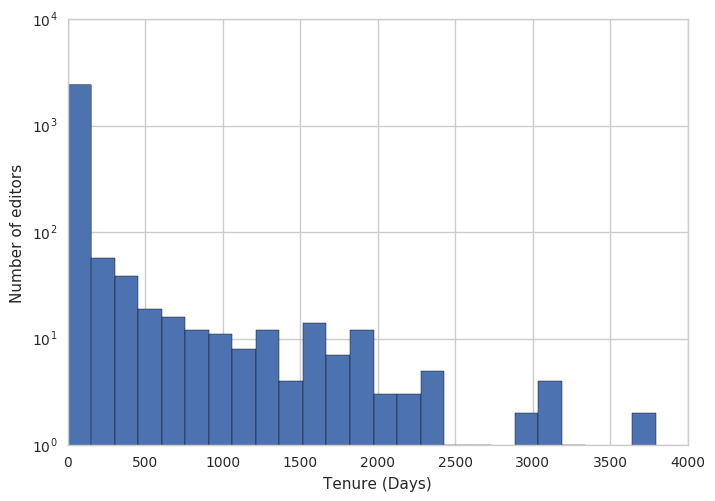

In [44]:
ax = rev_agg_user['tenure'].plot('hist',logy=True,bins=25)
ax.set_xlabel('Tenure (Days)')
ax.set_ylabel('Number of editors')

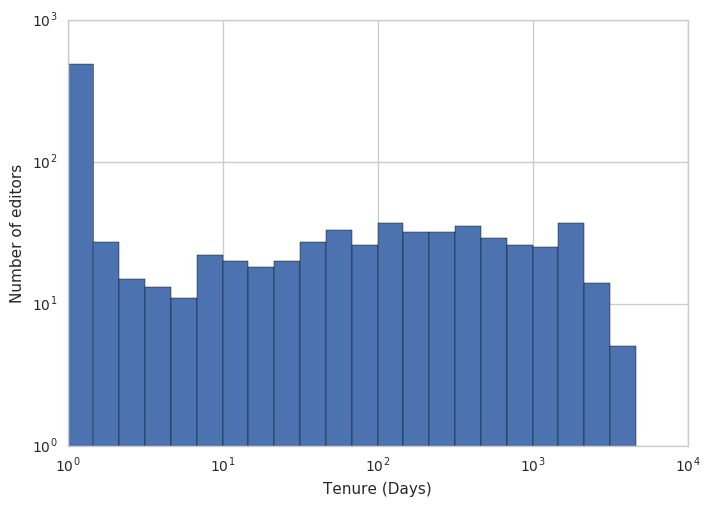

In [45]:
logspace_bins = np.logspace(start=0, stop=4, num=25)
ax = rev_agg_user['tenure'].plot('hist',logy=True,logx=True,bins=logspace_bins)
ax.set_xlabel('Tenure (Days)')
ax.set_ylabel('Number of editors')

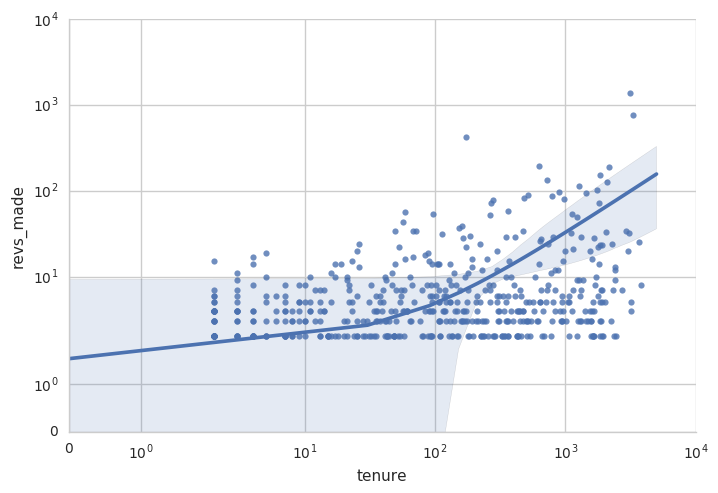

In [46]:
g = sb.lmplot(x='tenure',y='revs_made',data=rev_agg_user.query('tenure > 1'),aspect=1.5)
ax = g.axes[0][0]
ax.set_xlim((0,1e4))
ax.set_ylim((0,1e4))
ax.set_xscale('symlog')
ax.set_yscale('symlog')

### Get user info

Define a function `get_user_info` that takes a revision DataFrame containing a "rev_user" column/series. For all the users in the revision history, get their user information like regristration date and current edit count.

In [47]:
def get_user_info(rev_df,conn):
    if 'rev_user' in rev_df.columns:
        
        # Get all the user IDs from the revision DF
        _ids = rev_df['rev_user'].unique().tolist() 
        
        # Remove the 0s and convert the rest to strings
        _ids = [str(i) for i in _ids if i != 0]
        
        # Join the list of strings into a big comma-separated string
        user_string = ', '.join(_ids)
        
        # Write the query
        ## Select specific columns
        ## from the user table
        ## where the user_ids are among the users revising the article
        s = """
                SELECT 
                    user_id, user_name, user_registration, user_editcount
                FROM 
                    user
                WHERE
                    user_id IN ({0})
                ORDER BY
                    user_editcount DESC
            """.format(user_string)

        # Run the query
        _df = pd.read_sql_query(s,conn)
        
        # Some of the results have a "bytestring" format
        byte_columns = ['user_name','user_registration']
    
        # For each column, convert it from bytestring to a utf8 string
        for col in byte_columns:
            _df[col] = _df[col].str.decode('utf8')

        # Some of the values are missing, recode them as Jan 1, 2000
        _df['user_registration'] = _df['user_registration'].replace({None:'20000101000000'})
        
        # Convert timestamps to datetimes
        _df['user_registration'] = _df['user_registration'].apply(lambda x:pd.datetime.strptime(x,'%Y%m%d%H%M%S'))
        
        # Return the results
        return _df

Run the `get_user_info` function on the "rev_df" DataFrame to get information about each of the users who contributed to the article.

In [67]:
# Refresh the database connection since too much time has passed since the last query
conn.ping()
conn.cursor().execute('use enwiki_p');

# Get the user information.
rev_user_info_df = get_user_info(rev_df,conn)
rev_user_info_df.head()

,user_id,user_name,user_registration,user_editcount
0,1215485,Cydebot,2006-04-07 01:24:50,5337677
1,13286072,ClueBot NG,2010-10-20 17:01:19,4091964
2,433328,SmackBot,2005-09-13 22:47:59,3734324
3,6569922,Addbot,2008-03-01 21:58:03,2838809
4,7611264,AnomieBOT,2008-08-07 17:09:33,2555131


Merge the "rev_agg_user" and the "rev_user_info_df" DataFrames together by joining on the user name.

In [49]:
# Merge the two DataFrames together using the index of "reg_agg_user"
# and the "user_name" field from rev_user_info_df, joining on the left values which should be more inclusive
merged_rev_agg_user = pd.merge(rev_agg_user,rev_user_info_df,left_index=True,right_on='user_name',how='left')

# Check if the two DataFrames have the same number of users, if False then there will be NaNs
print(len(rev_agg_user) == len(rev_user_info_df))

# Show the first five rows
merged_rev_agg_user.head()

False


,last_rev,first_rev,rev_len_max,rev_len_med,rev_len_sum,rev_len_min,rev_ts_max,rev_ts_avg,rev_ts_min,revs_made,tenure,user_id,user_name,user_registration,user_editcount
694,2016-07-29 04:45:04,2016-07-29 04:45:04,0.0,0.0,0.0,0.0,3.742072,3.742072,3.742072,1,0.0,22197028.0,0xF8E8,2014-08-14 03:02:27,4900.0
1702,2012-07-27 18:21:26,2012-07-27 18:21:26,3.0,3.0,3.0,3.0,0.000405,0.000405,0.000405,1,0.0,NaN,108.16.207.9,NaT,NaN
1196,2012-09-09 02:29:06,2012-08-31 03:06:10,2468.0,2262.5,7021.0,28.0,0.235266,0.070113,0.002083,4,9.0,12697706.0,111Alpha,2010-07-08 14:42:31,243.0
1702,2012-07-22 12:09:15,2012-07-22 12:09:15,42.0,42.0,42.0,42.0,0.291343,0.291343,0.291343,1,0.0,NaN,117.18.231.7,NaT,NaN
1702,2012-07-25 01:35:02,2012-07-25 01:35:02,-112.0,-112.0,-112.0,-112.0,0.010289,0.010289,0.010289,1,0.0,NaN,119.11.151.33,NaT,NaN


What fraction of the user's toital edits are devoted to this single article?

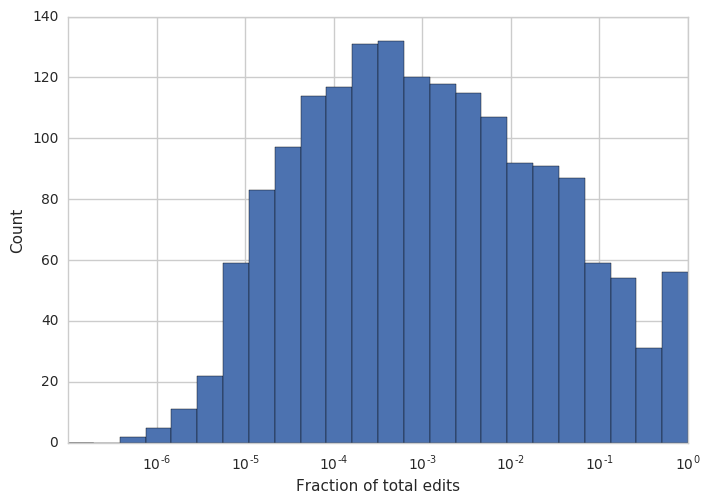

In [50]:
merged_rev_agg_user['rev_fraction'] = merged_rev_agg_user['revs_made']/merged_rev_agg_user['user_editcount']

# Plot the distribution. Use log-bins since the data is so skewed
logspace_bins = np.logspace(start=-7, stop=0, num=25)
ax = merged_rev_agg_user['rev_fraction'].plot('hist',logy=False,logx=True,bins=logspace_bins)
ax.set_xlabel('Fraction of total edits')
ax.set_ylabel('Count')

How long after a user's account registration did they make their first edit to this article?

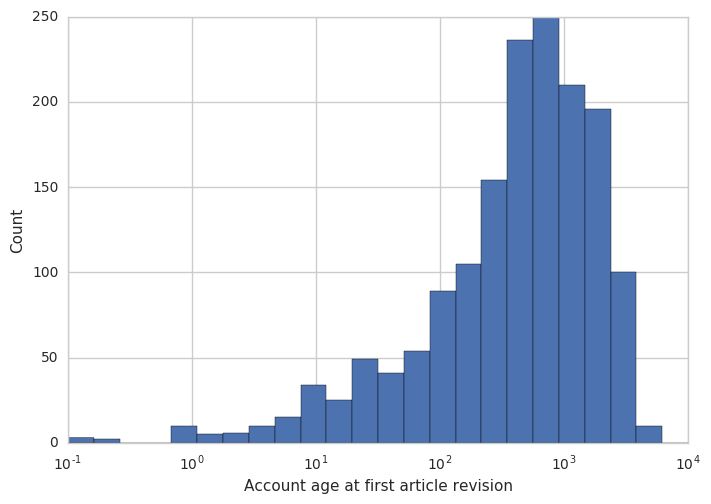

In [51]:
merged_rev_agg_user['first_rev_account_age'] = merged_rev_agg_user['first_rev'] - merged_rev_agg_user['user_registration']
merged_rev_agg_user['first_rev_account_age'] = merged_rev_agg_user['first_rev_account_age']/np.timedelta64(1,'D')

# Plot the distribution. Use log-bins since the data is so skewed
logspace_bins = np.logspace(start=-1, stop=4, num=25)
ax = merged_rev_agg_user['first_rev_account_age'].plot('hist',logy=False,logx=True,bins=logspace_bins)
ax.set_xlabel('Account age at first article revision')
ax.set_ylabel('Count')

Do users editing the article earlier in their career end up contributing more to the article?

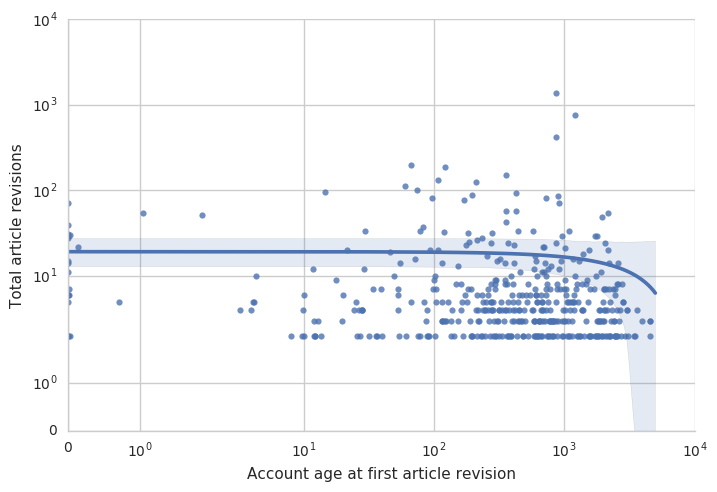

In [52]:
g = sb.lmplot(x='first_rev_account_age',y='revs_made',data=merged_rev_agg_user.query('tenure > 1'),aspect=1.5)
ax = g.axes[0][0]
ax.set_xlim((0,1e4))
ax.set_ylim((0,1e4))
ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.set_xlabel('Account age at first article revision')
ax.set_ylabel('Total article revisions')

## Compare two articles

In [53]:
# Refresh the database connection since too much time has passed since the last query
conn.ping()
conn.cursor().execute('use enwiki_p');

# Get the second set of revisions
rev2_df = get_page_revisions('John McCain',0,conn)

Do the data cleanup and feature engineering for later steps. Define a function to do all the feature engineering steps with one call.

In [54]:
def data_cleanup(rev_df):
    # Compute the rev_date from the timestamps
    rev_df['rev_date'] = rev_df['rev_timestamp'].apply(lambda x:x.date())

    # Set the revision lengths for the null rows to be the previous value
    rev_df['rev_len'] = rev_df['rev_len'].fillna(method='ffill')

    # Compute the diffs and store as a new series 
    rev_df['rev_len_diff'] = rev_df['rev_len'].diff()

    # Set the value for the first rev_len_diff to be the size of the rev_len
    rev_df.loc[0,'rev_len_diff'] = rev_df.loc[0,'rev_len']

    # Compute the diffs and store as a new series
    rev_df['rev_timestamp_diff'] = rev_df['rev_timestamp'].diff()

    # Convert the values of the new series to floats by dividing by 1 day time delta.
    rev_df['rev_timestamp_diff'] = rev_df['rev_timestamp_diff'].apply(lambda x:x/np.timedelta64(1,'D'))
    
    return rev_df

Run the cleanup on `rev2_df` and confirm it has all the variables (columns) we need.

In [55]:
rev2_df = data_cleanup(rev2_df)
rev2_df.head()

,rev_id,rev_page,rev_text_id,rev_comment,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len,rev_parent_id,rev_sha1,rev_content_model,rev_content_format,page_id,page_namespace,page_title,page_restrictions,page_counter,page_is_redirect,page_is_new,page_random,page_touched,page_links_updated,page_latest,page_len,page_content_model,rev_date,rev_len_diff,rev_timestamp_diff
0,27424,43715,0,*,0,128.12.181.70,2002-03-11 01:34:10,1,0,29,0,qfczsomdfu7wdhck9unyvohs0op9rgh,None,None,43715,0,John_McCain,,288,0,0,0.526428,2016-09-23 13:51:22,2016-09-23 11:26:45,736030052,192735,wikitext,2002-03-11,29.0,NaN
1,27841,43715,0,*,0,128.12.181.70,2002-03-11 01:34:45,0,0,37,27424,4vswcxsbepcaoum3ake4zd6pmynqjrt,None,None,43715,0,John_McCain,,288,0,0,0.526428,2016-09-23 13:51:22,2016-09-23 11:26:45,736030052,192735,wikitext,2002-03-11,8.0,0.000405
2,379846,43715,0,still a stub,0,140.247.197.26,2002-03-11 12:26:34,0,0,272,27841,0tjumke88mrriwguue9cfwz5wghj94o,None,None,43715,0,John_McCain,,288,0,0,0.526428,2016-09-23 13:51:22,2016-09-23 11:26:45,736030052,192735,wikitext,2002-03-11,235.0,0.452650
3,379849,43715,0,Added Brief Historical overview.,4956,Oscar Arias,2002-10-23 16:03:48,0,0,1197,379846,fibxhtkmlxca5jpgmd35awojd70jfm2,None,None,43715,0,John_McCain,,288,0,0,0.526428,2016-09-23 13:51:22,2016-09-23 11:26:45,736030052,192735,wikitext,2002-10-23,925.0,226.150856
4,379854,43715,0,,4956,Oscar Arias,2002-10-23 16:05:04,0,0,1205,379849,9prvxhxo01fum80jormhbky1dwo68zi,None,None,43715,0,John_McCain,,288,0,0,0.526428,2016-09-23 13:51:22,2016-09-23 11:26:45,736030052,192735,wikitext,2002-10-23,8.0,0.000880


Group by the "rev_date", compute the daily_revs, re-index to make the time continuous.

In [56]:
rev2_gb_date = rev2_df.groupby(['rev_date'])

daily_revs2 = rev2_gb_date.agg({'rev_id':pd.Series.nunique})

# Compute the first and last days revisions were observed
_min, _max = daily_revs2.index.min(), daily_revs2.index.max()

# Create a new index that is continuous over the whoel date range
_ix = pd.date_range(_min,_max)

# Reindex the daily revisions over the continuous date range filling in the blanks with 0s
daily_revs2_reindexed = daily_revs2.reindex(_ix).fillna(0)

Combine both of the daily_revs series into a DataFrame by merging, renaming the columns, and filling the blank values with 0s.

In [57]:
daily_revs_compared_df = pd.merge(daily_revs_reindexed,daily_revs2_reindexed,
                                  how='outer',left_index=True,right_index=True)

# The left DF was Mitt Romney and the right DF was John McCain. Rename to that effect
daily_revs_compared_df = daily_revs_compared_df.rename(columns={'rev_id_x':'Mitt Romney','rev_id_y':'John McCain'})

# Fill the null values with 0s
daily_revs_compared_df.fillna(0,inplace=True)

# Look at the first 5 rows
daily_revs_compared_df.head()

,Mitt Romney,John McCain
2002-03-11,0.0,3.0
2002-03-12,0.0,0.0
2002-03-13,0.0,0.0
2002-03-14,0.0,0.0
2002-03-15,0.0,0.0


Plot the comparisong of both results in a single chart. Use a rolling average of 60 days to smooth out noise.

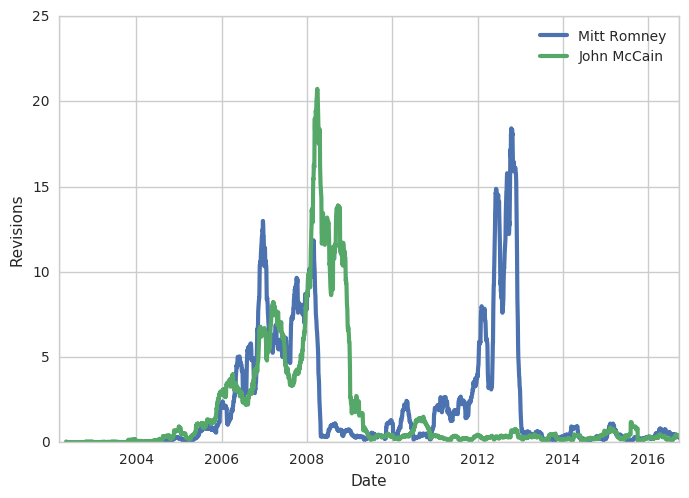

In [58]:
ax = daily_revs_compared_df.rolling(60).mean().plot(lw=3)

# Label the axes
ax.set_xlabel('Date')
ax.set_ylabel('Revisions')

Zoom in on the 2008 election season.

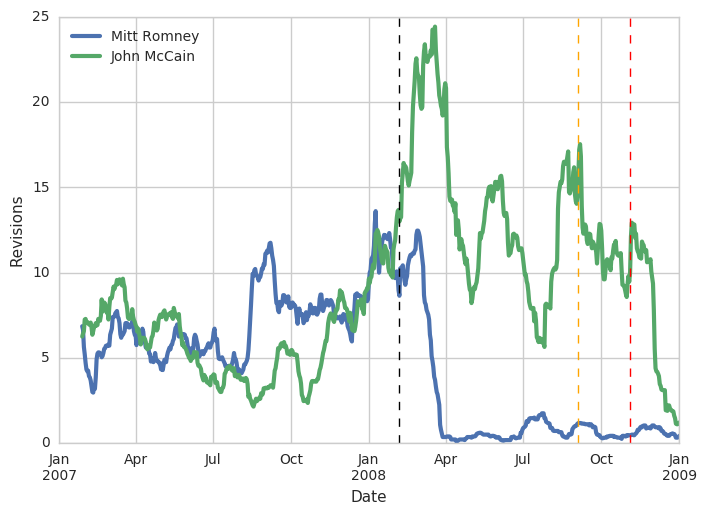

In [65]:
# Define two rough dates marking the start and stop of the election season
_min = pd.Timestamp('2007-01-01').date()
_max = pd.Timestamp('2009-01-01').date()

# Create a subset_df based on the 2-year window of dates
subset_df = daily_revs_compared_df.ix[_min:_max]

# Use a window of 28 days to compute the rolling average instead
ax = subset_df.rolling(28).mean().plot(lw=3)

# Draw a vertical lines for major campaign dates
ax.axvline(pd.Timestamp('2008-02-05').date(),c='black',lw=1,ls='--')   # Super Tuesday in black
ax.axvline(pd.Timestamp('2008-09-04').date(),c='orange',lw=1,ls='--')  # RNC in orange
ax.axvline(pd.Timestamp('2008-11-04').date(),c='red',lw=1,ls='--')     # Election day in red

ax.set_xlabel('Date')
ax.set_ylabel('Revisions')